### Load Data

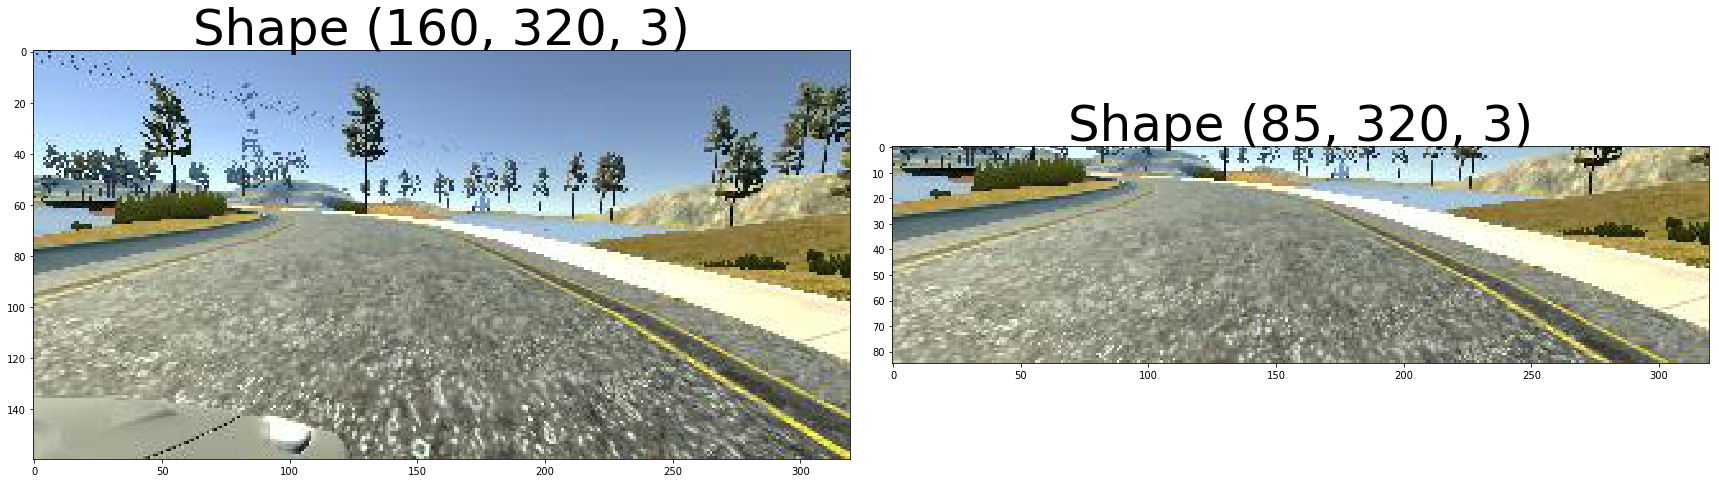

Orig std: 50.8952241394
Norm std: 50.1097
Orig mean: 149.791035156
Norm mean: 148.166


In [31]:
import csv
import cv2
import random
import sklearn
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout, Cropping2D
from keras import backend as ktf
from sklearn.model_selection import train_test_split
%matplotlib inline

correction = 0.2
samples = []
with open('./data/driving_log.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append((line[0].split('/')[-1], float(line[3])))
        samples.append((line[1].split('/')[-1], float(line[3])+correction))
        samples.append((line[2].split('/')[-1], float(line[3])-correction))
    
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

def read_sample(sample):
    image = cv2.cvtColor(cv2.imread('./data/IMG/' + sample[0]), cv2.COLOR_BGR2RGB)
    angle = float(sample[1])
    return image, angle

def compare_images(left_image, right_image):    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(left_image)
    ax1.set_title('Shape '+ str(left_image.shape), fontsize=50)
    ax2.imshow(np.uint8(right_image))
    ax2.set_title('Shape '+ str(right_image.shape), fontsize=50)
    plt.show()
    
    print('Orig std:', np.std(left_image))
    print('Norm std:', np.std(right_image))
    print('Orig mean:', np.mean(left_image))
    print('Norm mean:', np.mean(right_image))
    
image, angle = read_sample(train_samples[0])

model = Sequential()
model.add(Cropping2D(cropping=((50,25),(0,0)), input_shape=(160,320,3)))

new_img = model.predict(image[np.newaxis,...])
new_img = new_img.reshape(new_img.shape[1:])
                    
compare_images(image, new_img)

In [32]:
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1:
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                image = cv2.cvtColor(cv2.imread('./data/IMG/' + batch_sample[0]), cv2.COLOR_BGR2RGB)
                #image = normalize(image)
                angle = float(batch_sample[1])
                images.append(image)
                angles.append(angle)

            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

### Build and Train Model

In [27]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout, Cropping2D
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

train_generator = generator(train_samples, batch_size=256)
validation_generator = generator(validation_samples, batch_size=256)

model = Sequential()
model.add(Lambda(lambda x: x / 127.5 - 1.0, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((50,20),(0,0))))

model.add(Conv2D(6, (5, 5), activation="relu"))
model.add(MaxPooling2D())
model.add(Conv2D(6, (5, 5), activation="relu"))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(120))
model.add(Dropout(0.5))
model.add(Dense(84))
model.add(Dropout(0.5))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
#model.fit(X_train, y_train, validation_split=0.2, shuffle=True, epochs=5)
model.fit_generator(train_generator, 
                    steps_per_epoch=len(train_samples)/256, 
                    validation_data=validation_generator, 
                    validation_steps=len(validation_samples)/256, 
                    nb_epoch=20)

model.save('model1.h5')

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:31: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:31: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_steps=8.36328125, epochs=20, validation_data=<generator..., steps_per_epoch=33.4375)`


Epoch 1/20
34/33 [==============================] - 52s - loss: 0.7514 - val_loss: 0.0483
Epoch 2/20
34/33 [==============================] - 42s - loss: 0.0458 - val_loss: 0.0369
Epoch 3/20
34/33 [==============================] - 42s - loss: 0.0398 - val_loss: 0.0354
Epoch 4/20
34/33 [==============================] - 42s - loss: 0.0380 - val_loss: 0.0339
Epoch 5/20
34/33 [==============================] - 42s - loss: 0.0362 - val_loss: 0.0322
Epoch 6/20
34/33 [==============================] - 42s - loss: 0.0338 - val_loss: 0.0301
Epoch 7/20
34/33 [==============================] - 42s - loss: 0.0328 - val_loss: 0.0280
Epoch 8/20
34/33 [==============================] - 42s - loss: 0.0307 - val_loss: 0.0262
Epoch 9/20
34/33 [==============================] - 41s - loss: 0.0294 - val_loss: 0.0250
Epoch 10/20
34/33 [==============================] - 42s - loss: 0.0278 - val_loss: 0.0238
Epoch 11/20
34/33 [==============================] - 41s - loss: 0.0266 - val_loss: 0.0229
Epoch 12

In [33]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout, Cropping2D
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

model = Sequential()
model.add(Lambda(lambda x: x / 127.5 - 1.0, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((50,20),(0,0))))

model.add(Conv2D(24, (5, 5), activation="relu", strides=(2, 2)))
model.add(Conv2D(36, (5, 5), activation="relu", strides=(2, 2)))
model.add(Conv2D(48, (5, 5), activation="relu", strides=(2, 2)))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dropout(0.5))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
#model.fit(X_train, y_train, validation_split=0.2, shuffle=True, epochs=5)
model.fit_generator(train_generator, 
                    steps_per_epoch=len(train_samples)/256, 
                    validation_data=validation_generator, 
                    validation_steps=len(validation_samples)/256, 
                    nb_epoch=10)

model.save('model.h5')

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:29: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:29: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_steps=8.36328125, epochs=10, validation_data=<generator..., steps_per_epoch=33.4375)`


Epoch 1/10
34/33 [==============================] - 52s - loss: 0.0338 - val_loss: 0.0233
Epoch 2/10
34/33 [==============================] - 42s - loss: 0.0234 - val_loss: 0.0205
Epoch 3/10
34/33 [==============================] - 43s - loss: 0.0217 - val_loss: 0.0190
Epoch 4/10
34/33 [==============================] - 42s - loss: 0.0204 - val_loss: 0.0190
Epoch 5/10
34/33 [==============================] - 42s - loss: 0.0196 - val_loss: 0.0169
Epoch 6/10
34/33 [==============================] - 42s - loss: 0.0190 - val_loss: 0.0176
Epoch 7/10
34/33 [==============================] - 41s - loss: 0.0180 - val_loss: 0.0157
Epoch 8/10
34/33 [==============================] - 43s - loss: 0.0164 - val_loss: 0.0148
Epoch 9/10
34/33 [==============================] - 42s - loss: 0.0157 - val_loss: 0.0145
Epoch 10/10
34/33 [==============================] - 42s - loss: 0.0150 - val_loss: 0.0133
